In [1]:
import json

import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from scipy.stats import kurtosis, skew, norm, exponnorm, expon

%matplotlib notebook

In [2]:
years = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/years.csv")
team_years = pd.read_csv("https://raw.githubusercontent.com/avgupta456/statbotics-csvs/main/team_years.csv")

In [3]:
elo_years = []
for year in range(2002, 2021):
    elo_years.append(team_years[team_years.year == year]["elo_mean"])
elo_years.append(team_years.elo_mean)

In [4]:
print("Year\tMean\tSD  \t\tSkew\t\tKurtosis")
for i, year_data in enumerate(elo_years[:-1]):
    print(2002 + i, "\t", round(year_data.mean()), "\t", round(year_data.std(), 2), "  \t", round(skew(year_data), 2), "\t\t", round(kurtosis(year_data), 2))
print("All", "\t", round(elo_years[-1].mean()), "\t", round(elo_years[-1].std(), 2), "  \t", round(skew(elo_years[-1]), 2), "\t\t", round(kurtosis(elo_years[-1]), 2))

Year	Mean	SD  		Skew		Kurtosis
2002 	 1500 	 35.88   	 0.33 		 0.21
2003 	 1478 	 62.51   	 0.46 		 0.08
2004 	 1483 	 68.66   	 1.05 		 1.44
2005 	 1489 	 88.29   	 0.91 		 1.09
2006 	 1482 	 77.08   	 1.62 		 4.17
2007 	 1484 	 77.75   	 1.73 		 5.48
2008 	 1485 	 72.14   	 1.82 		 5.52
2009 	 1484 	 76.62   	 1.42 		 3.01
2010 	 1485 	 77.43   	 2.06 		 7.72
2011 	 1486 	 79.09   	 2.01 		 5.68
2012 	 1486 	 73.59   	 1.94 		 5.54
2013 	 1488 	 80.56   	 1.87 		 5.45
2014 	 1490 	 86.23   	 1.51 		 3.24
2015 	 1497 	 82.48   	 2.0 		 6.34
2016 	 1500 	 76.46   	 1.45 		 3.38
2017 	 1501 	 73.44   	 0.79 		 0.73
2018 	 1505 	 99.94   	 1.12 		 1.36
2019 	 1512 	 85.08   	 0.91 		 0.94
2020 	 1533 	 85.93   	 0.75 		 0.44
All 	 1496 	 81.72   	 1.41 		 3.16


<IPython.core.display.Javascript object>


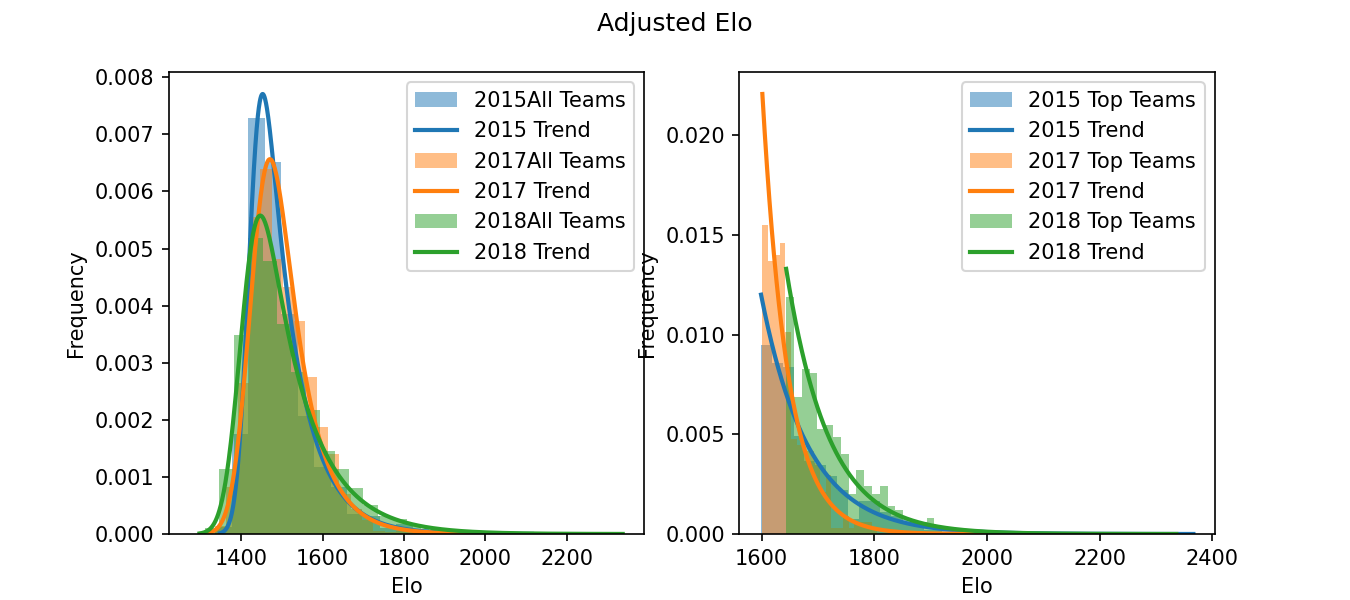

In [5]:
def get_subset(data):
    return data[(data > data.quantile(0.90)) & (data < data.quantile(0.999))]


fig, axs = plt.subplots(1, 2, figsize=(9, 4))

colors = ['tab:blue', 'tab:orange', 'tab:green']

for color, year in zip(colors, [2015, 2017, 2018]):
    all_data = elo_years[year - 2002]
    data = get_subset(all_data)

    config = exponnorm.fit(all_data)
    axs[0].hist(all_data, density=True, bins=20, alpha=0.5, color=color, label=str(year) + "All Teams")
    x = np.linspace(exponnorm.ppf(0.0001, *config), exponnorm.ppf(0.9999, *config), 1000)
    axs[0].plot(x, exponnorm.pdf(x, *config), lw=2, color=color, label=str(year) + " Trend")
    fig.show()

    config2 = expon.fit(data)
    axs[1].hist(data, density=True, bins=20, alpha=0.5, color=color, label=str(year) + " Top Teams")
    x = np.linspace(expon.ppf(0.0001, *config2), expon.ppf(0.9999, *config2), 1000)
    axs[1].plot(x, expon.pdf(x, *config2), lw=2, color=color, label=str(year) + " Trend")
    
axs[0].set_xlabel("Elo")
axs[0].set_ylabel("Frequency")
axs[1].set_xlabel("Elo")
axs[1].set_ylabel("Frequency")

fig.suptitle("Adjusted Elo")

axs[0].legend()
axs[1].legend()
fig.show()

In [6]:
all_configs = [exponnorm.fit(year_data) for year_data in elo_years]
configs = [expon.fit(get_subset(year_data)) for year_data in elo_years]

In [7]:
team_years["elo_adj"] = 0

for year in range(2002, 2021):
    print(year)
    cutoff = team_years[team_years.year == year].elo_mean.quantile(0.90)
    subset = (team_years.year == year) & (team_years.elo_mean > cutoff)
    team_years.loc[team_years.year == year, "elo_adj"] = exponnorm.ppf(exponnorm.cdf(team_years[team_years.year == year].elo_mean, *all_configs[year - 2002]), *all_configs[-1])
    team_years.loc[subset, "elo_adj"] = expon.ppf(expon.cdf(team_years[subset].elo_mean, *configs[year - 2002]), *configs[-1])

2002
2003
2004
2005
2006
2007
2008
2009
2010
2011
2012
2013
2014
2015
2016
2017
2018
2019
2020


In [8]:
cols = ["year", "team", "elo_mean", "winrate", "opr_rank", "elo_rank", "elo_adj"]
team_years.sort_values(by=["elo_adj"], ascending=False)[cols].head(20)

,year,team,elo_mean,winrate,opr_rank,elo_rank,elo_adj
12596,2010,1114,2076.69,0.9437,2,2,2049.597178
22045,2015,1114,2144.74,0.9079,3,1,2042.705507
9472,2007,1114,2004.73,0.8158,304,1,2042.642529
4575,2010,469,2060.02,0.7597,1,1,2034.704376
6820,2017,254,1891.13,0.8644,3,1,2032.503170
17958,2013,2056,2054.36,0.9104,3,2,2018.893224
10287,2008,1114,2021.89,0.8939,1,1,2018.121242
338,2007,25,1978.90,0.7857,237,3,2015.558982
17585,2013,1114,2042.17,0.9030,2,1,2007.964219
3366,2007,330,1959.33,0.8776,150,2,1995.039237


In [9]:
display(team_years.sort_values(by="elo_adj", ascending=False)[cols].head(100).groupby("year").agg({"team": "count"}).sort_values(by="team", ascending=False))

,team
year,
2016,11
2017,11
2014,9
2012,8
2013,8
2019,7
2010,7
2015,7
2011,5


<IPython.core.display.Javascript object>


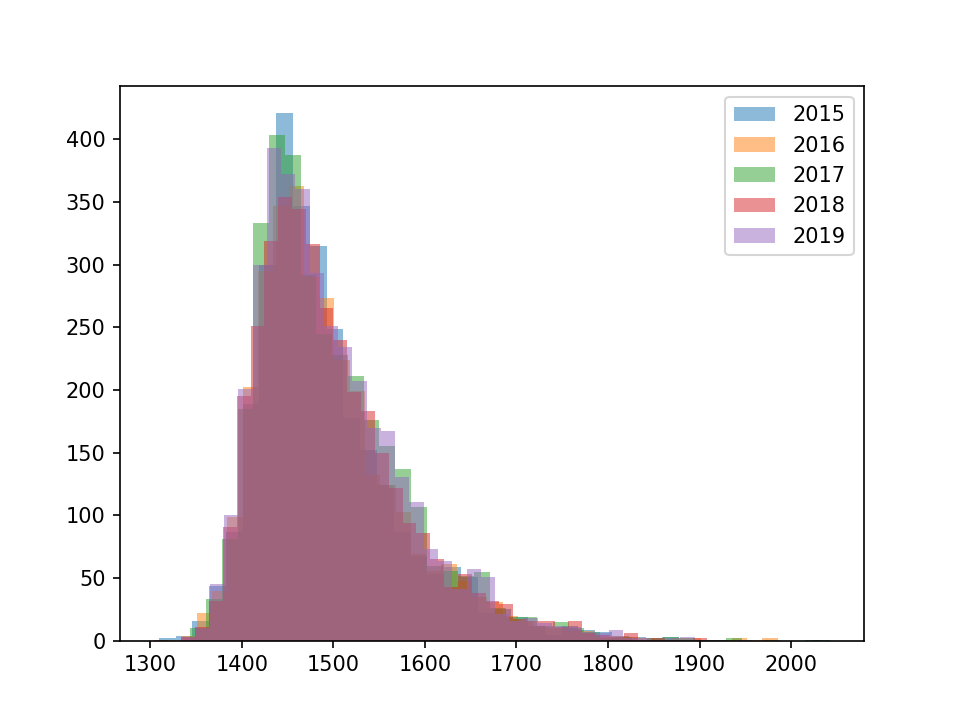

In [10]:
fig, ax = plt.subplots()
for year in range(2015, 2020):
    ax.hist(team_years[team_years.year == year].elo_adj, bins=40, alpha=0.5, label=str(year))
ax.legend()
fig.show()

<IPython.core.display.Javascript object>


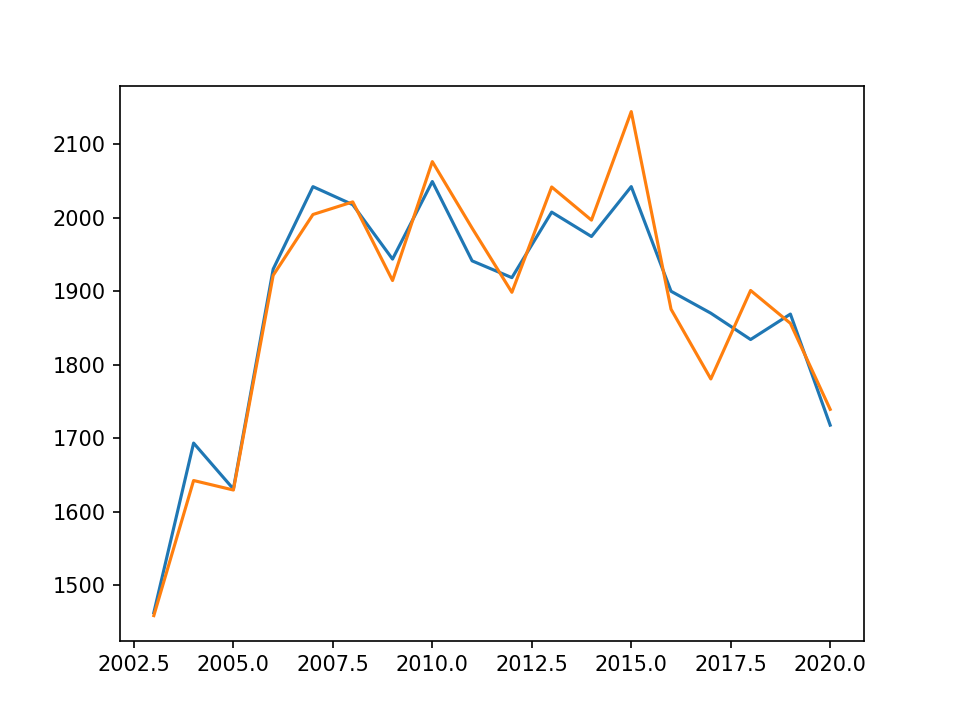

In [11]:
fig, ax = plt.subplots()
data = team_years[team_years.team == 1114]

ax.plot(data.year, data.elo_adj)
ax.plot(data.year, data.elo_mean)
fig.show()

In [12]:
from collections import defaultdict

counts = defaultdict(int)

first_year = 2002
last_year = 2018
print("      ", end="")
for year in range(first_year, last_year + 1):
    print(str(year).rjust(6), end="")
print()
for start_year in range(first_year, last_year + 1):
    print(start_year, end="  ")
    for year in range(first_year, start_year):
        print(end="      ")
    for end_year in range(start_year, last_year + 1):
        data = team_years[(team_years.year >= start_year) & (team_years.year <= end_year)].groupby("team").agg({"team": "mean", "year": "count", "elo_adj": "mean"})
        data = data[data.year == end_year - start_year + 1].sort_values(by=["elo_adj"], ascending=False)
        team = round(data.iloc[0, 0])
        counts[team] += 1
        print(str(team).rjust(6), end="")
    print()

        2002  2003  2004  2005  2006  2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  2017  2018
2002      68   358    60    60   233   233   233   233   233   233   469   469   469   254   254   254   254
2003           522   233   233   233   233   233   233  1114  1114  1114  1114  1114  1114  1114  1114  1114
2004                 233   233   233   233   233  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114
2005                       233   233   233  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114
2006                             233  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114
2007                                  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114
2008                                        1114  1114  1114  1114  1114  1114  1114  1114  1114  1114  1114
2009                                              1114  1114  1114  1114  1114  1114  1114  1114  1114  1114
2010               

In [13]:
print("Team\tCount")
for item in sorted(counts.items(), key=lambda x: -x[1]):
    print(item[0], "\t", item[1])

Team	Count
1114 	 100
233 	 21
254 	 18
2056 	 6
469 	 3
60 	 2
68 	 1
358 	 1
522 	 1
